In [1]:
import pickle
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import torch
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.functional import cosine_similarity
import pandas as pd

### Load embeddings

In [3]:
embeddings_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/e4e_embeddings_from_saved.pt"

In [4]:
embeddings_dict = torch.load(embeddings_path)
embeddings = torch.stack(list(embeddings_dict.values())).squeeze(1)

### Calculate Morph

In [5]:
morph = embeddings.mean(axis = 0)

### Calculate Cosine Distance between each article and morph as typicality scores

In [6]:
typicality_scores = {k:cosine_similarity(morph, v.squeeze(0), dim=-1).item() for k,v in embeddings_dict.items()}

# Save to pickle
save_path = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/entangled_typicality/typicality_scores.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(typicality_scores, f)

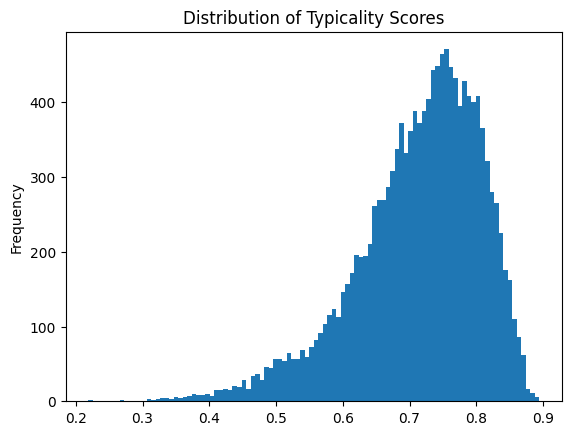

In [7]:
d = pd.Series(typicality_scores)
d.plot(kind = 'hist', bins =100)
plt.title("Distribution of Typicality Scores")
plt.show()

### Plot some examples

In [8]:
# Load in e4e latents
e4e_latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

In [23]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

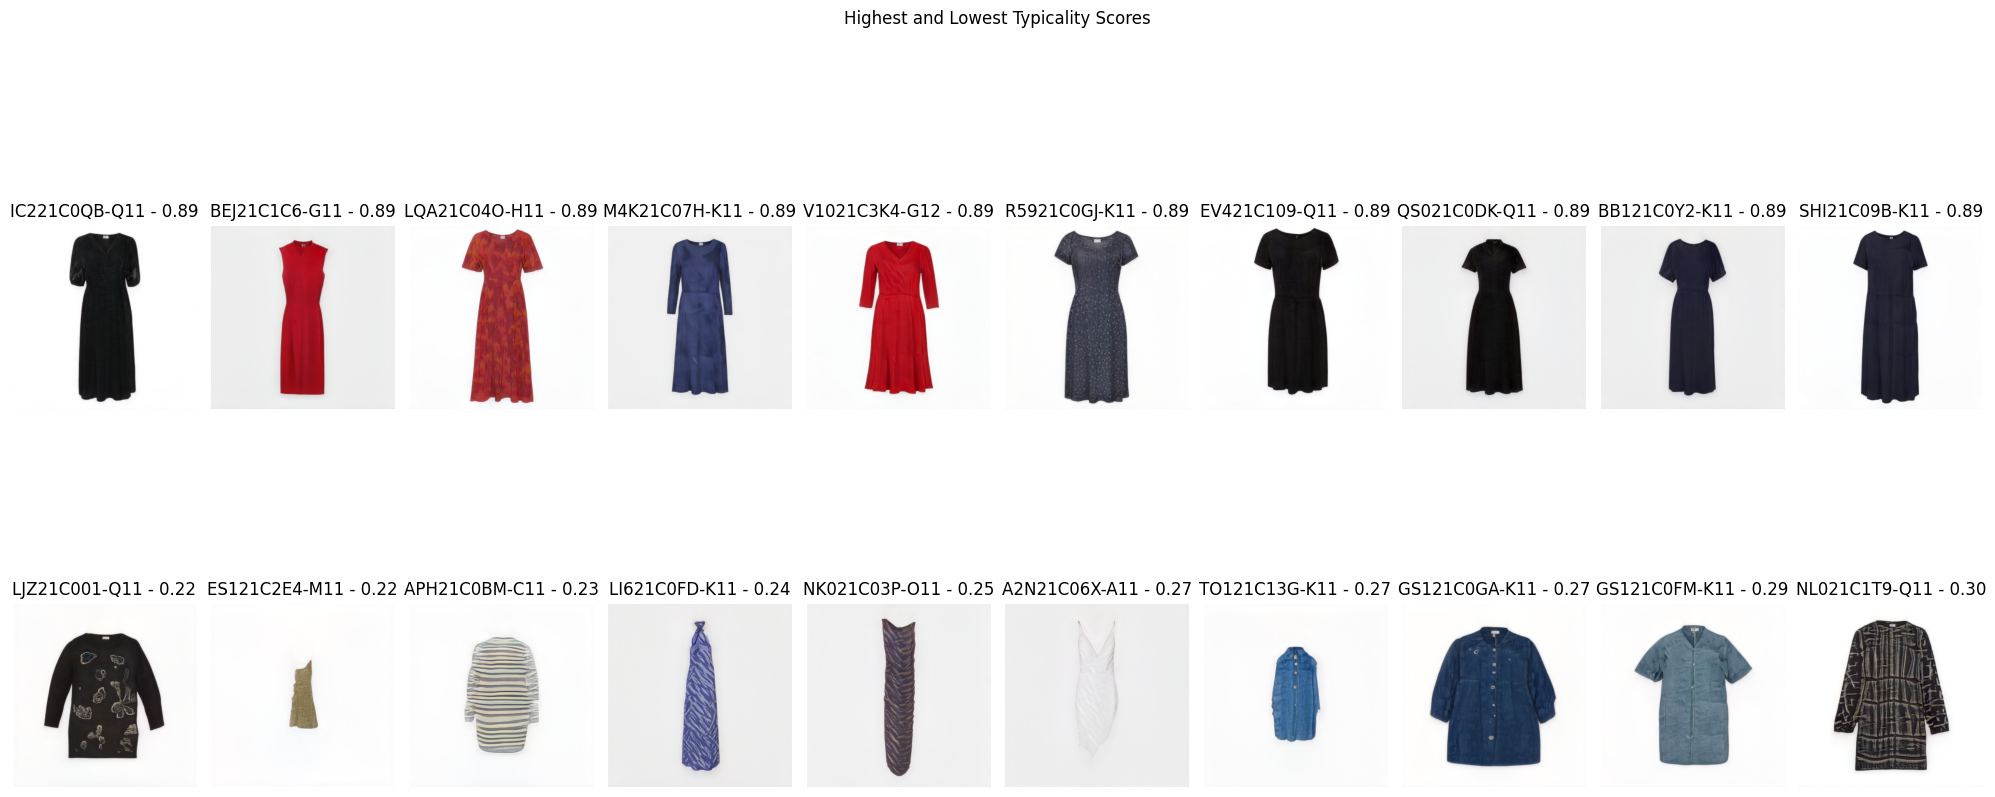

In [10]:
# Plot n highest and lowest typicality scores
n = 10

highest = d.nlargest(n)
lowest = d.nsmallest(n)

fig, axs = plt.subplots(2, n, figsize = (20, 10))
for i, (k, v) in enumerate(highest.items()):
    latent = e4e_latents[k]
    img = generate_from_latent(latent)
    axs[0, i].imshow(img)
    axs[0, i].set_title(f"{k} - {v:.2f}")
    axs[0, i].axis('off')


for i, (k, v) in enumerate(lowest.items()):
    latent = e4e_latents[k]
    img = generate_from_latent(latent)
    axs[1, i].imshow(img)
    axs[1, i].set_title(f"{k} - {v:.2f}")
    axs[1, i].axis('off')

plt.suptitle("Highest and Lowest Typicality Scores")
fig.tight_layout()
plt.show()